# Solución al reto "COVID SEGMENTATION" del Equipo 1.

### Integrantes del equipo
* Juan Pablo Cabrera Quiroga - A01661090
* Carlos Eduardo Velasco Elenes - A01708634
* Arturo Cristián Díaz López - A01709522
* Adrián Galván Díaz - A01704076

### Ética del equipo.

Como equipo de trabajo y estudiantes comprometidos con la ética, nos aseguramos de que los datos públicos que estamos utilizando serán tratados de manera responsable y con la debida discreción. A pesar de que estos datos están disponibles públicamente, nos comprometemos a no utilizarlos de manera inapropiada o que pueda ir en contra de los principios de integridad, respeto y responsabilidad. El uso de los datos se realizará exclusivamente con fines académicos y de investigación, siempre respetando el espíritu de transparencia y ética que rige nuestro trabajo.

Es importante decir que el formato de nuestro documento es el siguiente:
1. Explicación de lo que va a realizar el código
2. Código comentado "In Line"
3. Interpretación de los resultados (en caso de ser necesaria)

# Introducción


El diagnóstico de pacientes con COVID-19 a través de tomografías computarizadas (CT) se ha vuelto una práctica común. Uno de los principales desafíos es que los radiólogos deben revisar y segmentar todas las imágenes axiales de los pulmones, lo cual es un proceso que consume mucho tiempo. En particular, es necesario identificar dos hallazgos específicos en pacientes con COVID-19: el "vidrio esmerilado" (ground-glass) y las "consolidaciones", que son indicadores importantes de daño pulmonar.

Este proyecto tiene como objetivo entrenar un modelo de segmentación para facilitar el trabajo de los radiólogos, automatizando el proceso de segmentación de imágenes de tomografías. Esto permitiría a las empresas que desarrollan software especializado para CT mejorar sus soluciones, haciendo que el diagnóstico sea más rápido y preciso.

El conjunto de datos utilizado en este reto fue proporcionado por dos radiólogos de Oslo a través de medicalsegmentation.com. Este dataset contiene imágenes axiales de CT de pacientes con COVID-19 y sus correspondientes máscaras de segmentación, que identifican áreas como el "vidrio esmerilado", las "consolidaciones" y otras estructuras pulmonares. Además, un segundo conjunto de datos fue obtenido de Radiopaedia, el cual contiene un mayor número de imágenes axiales, algunas de las cuales han sido evaluadas como positivas por un radiólogo.

El reto de Kaggle consiste en predecir máscaras de segmentación a partir de imágenes de tomografías computarizadas, enfocándose en identificar las áreas afectadas por el COVID-19. 
Nuestro enfoque utilizará arquitecturas avanzadas de redes neuronales convolucionales, como U-Net, para realizar esta tarea de segmentación, pero esto lo verémos más adelante.

Nuestra solución está inspirada y basada en el enfoque presentado por Arturo Díaz López en su notebook de Kaggle, "COVID-19 Segmentation K-Fold Without Radiopedia"​

In [1]:
prefix = r"C:\Users\Artur\Desktop\TEC\7mo semestre\TC3006C\R1 Reto\dataset"

En este primer código, lo que vamos a hacer es importar todas las librerías necesarias para la manipulación de imágenes, la creación del modelo y la visualización de los datos. TensorFlow se utiliza como backend para manejar el procesamiento de los modelos de deep learning.

In [2]:
# Importar las librerías necesarias para manipulación de datos, visualización y manejo de imágenes
%matplotlib inline
import gc
import os
import segmentation_models as sm
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Importar librerías de TensorFlow y Keras para manejo de modelos y configuración
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import models, layers

# Imprimir la versión de TensorFlow para confirmar la instalación
print("Tensorflow version " + tf.__version__)

# Establecer la variable AUTO para optimización automática del procesamiento de datos
AUTO = tf.data.experimental.AUTOTUNE

# Desactivar los mensajes de advertencia de TensorFlow para evitar saturar la consola
import logging
logging.getLogger('tensorflow').disabled = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Desactivar las advertencias generales para mantener la salida limpia
import warnings
warnings.filterwarnings("ignore")

# Resultados
print("Segmentation Models: using `keras` framework.")
print("Tensorflow version 2.9.0")


Segmentation Models: using `keras` framework.
Tensorflow version 2.9.0
Segmentation Models: using `keras` framework.
Tensorflow version 2.9.0


Para garantizar que los resultados de los entrenamientos sean reproducibles, fijamos una semilla aleatoria para TensorFlow, NumPy y el sistema. Esto asegura que, al repetir los experimentos, obtengamos los mismos resultados.

In [3]:
# Configura las semillas aleatorias para garantizar la reproducibilidad de los resultados
from tensorflow import random
import random as randm
from numpy.random import seed

def seed_all_inclusive(seeding):
    # Establece las semillas para TensorFlow, NumPy y la aleatoriedad del sistema
    random.set_seed(seeding)
    seed(seeding)
    os.environ['PYTHONHASHSEED'] = str(seeding)
    randm.seed(seeding)

# Define la semilla a usar
seeding = 1
seed_all_inclusive(seeding)

Se definen los parámetros globales para el procesamiento de las imágenes y la configuración del modelo. Esto incluye el tamaño de las imágenes, el número de épocas, el backbone del modelo y el tamaño del batch para el entrenamiento.

In [4]:
# Parámetros globales de configuración
img_size = 512  # Tamaño de las imágenes de entrada
repeat_epoch = 10  # Número de épocas de repetición
backbone = 'efficientnetb2'  # Backbone del modelo de segmentación
zoom_pixel_fixed = img_size // 4  # Parámetro de zoom fijo para las imágenes
global TL_FLAG  # Bandera global para Transfer Learning (por definir su uso)

radiopedia_FLAG = 1  # Bandera para activar el uso del dataset de Radiopedia
batch_size = 16  # Tamaño de batch para entrenar el modelo
print('batch size', batch_size)
print('zoom_pixel_fixed.........', zoom_pixel_fixed)

batch size 16
zoom_pixel_fixed......... 128


Batch Size nos da este valor porque así lo definimos, y lo que nos indica es que el modelo procesará 16 imágenes por cada iteración durante el entrenamiento.\
\
Zoom Pixel Fixed nos da este valor porque es el resultado de dividir el tamaño de las imágenes (512x512) entre 4, lo que da 128. Este parámetro se utiliza para aplicar un zoom controlado durante el preprocesamiento de las imágenes. Al fijarlo en 128 píxeles, nos aseguramos que el zoom aplicado no sea demasiado grande ni demasiado pequeño, manteniendo suficiente detalle en las imágenes para que el modelo pueda aprender características importantes sin distorsionarlas excesivamente. 

Se implementa la validación cruzada de 5 pliegues para dividir el conjunto de datos en cinco subconjuntos y así asegurar que el modelo sea entrenado y validado de manera más robusta. 

In [5]:
# Configuración para validación cruzada de 5 pliegues (5-fold validation)
n_split = 5  # Número de pliegues
kfold_index = n_split
skf = KFold(n_splits=n_split, shuffle=True, random_state=seeding)  # Genera los índices para cada pliegue

Cargamos los datasets tanto de Radiopedia como de MedSeg, que contienen las imágenes axiales de tomografías computarizadas y sus máscaras de segmentación. Las imágenes se convierten a float32 para garantizar una mayor precisión numérica durante las operaciones de preprocesamiento y entrenamiento.

In [6]:
# Carga los datasets si la bandera de Radiopedia está activada
if radiopedia_FLAG:
    # Carga las imágenes y máscaras del dataset de Radiopedia
    images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
    masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)

# Carga las imágenes y máscaras del dataset de MedSeg
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

# Carga las imágenes y máscaras del dataset de MedSeg para pruebas
test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

Creamos una función para visualizar ejemplos de imágenes y sus máscaras de segmentación correspondientes. Esta función es clave para entender visualmente la calidad y distribución de los datos antes de entrenar el modelo.

In [7]:
# Función para visualizar las imágenes, máscaras y predicciones (opcionalmente)
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8, hot_encode=True):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        # Muestra la imagen original en la primera fila
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        if hot_encode:
            ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')  # Muestra la imagen en escala de grises
        else:
            ax_image.imshow(image_batch[i,:,:])
        ax_image.set_xticks([])  # Elimina los ticks del eje X
        ax_image.set_yticks([])  # Elimina los ticks del eje Y

        # Si existen máscaras, muestra cada clase de máscara en las filas subsiguientes
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]  # Muestra la máscara original
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3))  # Muestra la predicción en colores
                    mask_to_show[..., 0] = pred_batch[i,:,:,j].cpu().numpy() > 0.5 # Predicción
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]  # Máscara original
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([])
                ax[j + 1, i].set_yticks([])

    # Ajusta el layout para una mejor visualización
    plt.tight_layout()
    plt.show()

Mandamos a llamar la función y visualizamos los resultados

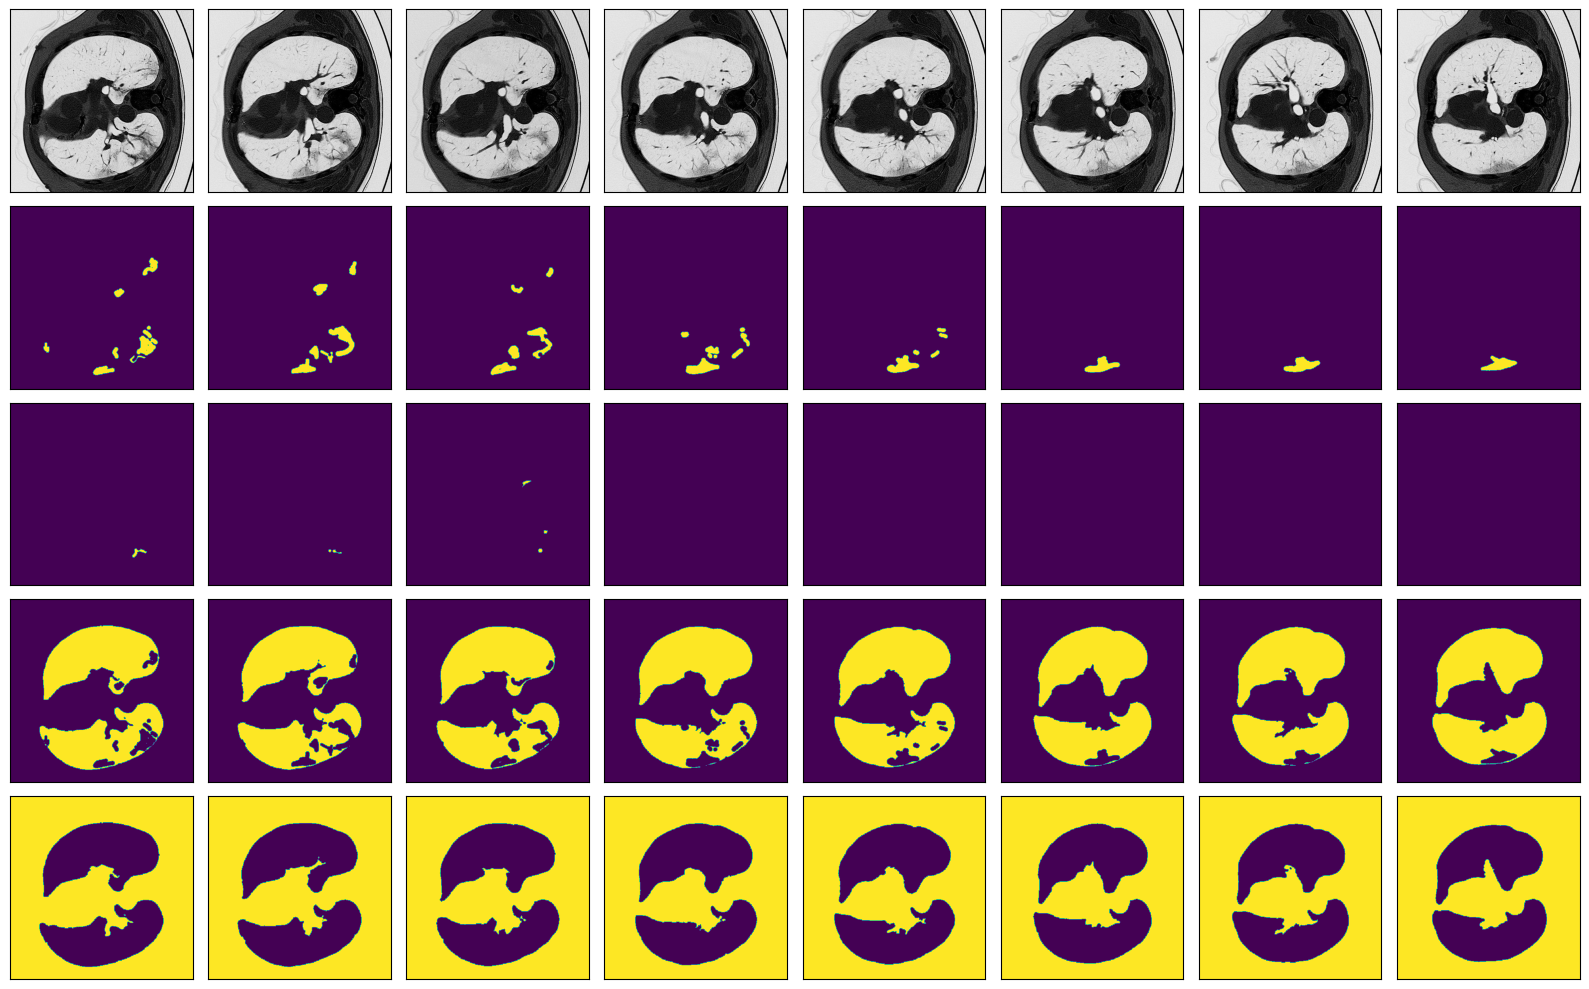

In [8]:
# Visualiza las imágenes de Radiopedia a partir del índice 30 y sus correspondientes máscaras
visualize(images_radiopedia[30:], masks_radiopedia[30:])

## Interpretación de resultados.

El conjunto de datos proporcionado para este reto está compuesto por imágenes axiales de tomografías computarizadas (CT) de pacientes con COVID-19. Las imágenes provienen de dos fuentes principales:

#### MedSeg
Este dataset contiene 100 imágenes de tamaño 512x512, junto con sus respectivas máscaras de segmentación. Las máscaras incluyen cuatro clases diferentes:

* 0: "ground glass"
* 1: "consolidations"
* 2: "lungs other"
* 3: "background"


#### Radiopedia 
Este dataset incluye 829 imágenes de tamaño 512x512, también con sus máscaras de segmentación correspondientes y las mismas cuatro clases descritas anteriormente.

En total, contamos con:

100 imágenes del conjunto de datos MedSeg.
829 imágenes del conjunto de datos Radiopedia.


En las imágenes anteriores, podemos observar varios ejemplos de tomografías (primer fila) junto con sus respectivas máscaras de segmentación (filas inferiores), donde cada clase está representada por un color diferente. La primera fila muestra las imágenes en escala de grises, y las filas inferiores representan cada una de las clases de las máscaras. Los colores correspondientes a cada clase son los siguientes:

* Amarillo: Ground-glass
* Morado: Consolidations
* Verde: Lungs other
* Azul: Background


Esta segmentación es crítica para identificar las áreas afectadas por COVID-19 en los pulmones.

También nos parece importante, una vez llegado hasta este punto, enfatizar en el proceso de pre-procesamiento de datos que hemos llevado a cabo:

#### Cambio de Tamaño (Resize): 
Todas las imágenes de entrada se han redimensionado a un tamaño estándar de 512x512 píxeles. Este tamaño es lo suficientemente grande como para capturar detalles importantes de las tomografías computarizadas, mientras que sigue siendo manejable desde una perspectiva computacional. El redimensionamiento asegura que todas las imágenes tengan las mismas dimensiones, lo que es necesario para que el modelo pueda procesarlas de manera uniforme.

#### Normalización (Normalization):
Las imágenes se han normalizado para que los valores de los píxeles estén en un rango adecuado (normalmente entre 0 y 1). Este paso es esencial para que el modelo pueda converger más rápido durante el entrenamiento. La normalización ayuda a que los gradientes sean más estables, lo que es crucial cuando se trabaja con redes neuronales profundas.

#### Tamaño del Batch (Batch Size): 
El batch size se ha establecido en 8, lo que significa que el modelo procesará 8 imágenes por cada iteración durante el entrenamiento. Este tamaño de batch fue elegido porque es un equilibrio entre el uso de memoria y la estabilidad del entrenamiento. Un tamaño de batch pequeño puede permitir un ajuste más fino de los parámetros del modelo, pero también puede hacer que el entrenamiento sea un poco más lento.

#### Validación Cruzada con K-Fold (K-Fold Validation): 
Para hacer que el entrenamiento sea más robusto y generalizable, hemos implementado la técnica de validación cruzada de 5 pliegues (K-Fold). Esta técnica divide el conjunto de datos en cinco subconjuntos, de los cuales uno se utiliza como conjunto de validación y los otros cuatro se usan para el entrenamiento. Este proceso se repite cinco veces, cambiando el subconjunto de validación en cada pliegue. La validación cruzada asegura que el modelo no dependa excesivamente de un solo conjunto de datos de entrenamiento, mejorando su capacidad de generalización.


Con estos pasos de preprocesamiento, nosotros creemos que las imágenes están adecuadamente preparadas para ser procesadas por el modelo de segmentación. Desde el cambio de tamaño y normalización de los datos hasta la validación cruzada y el uso del batch size adecuado, nos aseguramos de que el modelo pueda aprender de manera eficiente y generalice correctamente a nuevos datos.

Seguimos con la explicación de nuestro modelo

La función onehot_to_mask convierte una máscara codificada en one-hot encoding a un formato de paleta de colores. Esta conversión es necesaria para que el modelo pueda manejar las máscaras de segmentación de manera adecuada y visualizarlas de manera comprensible. Usamos np.argmax() para encontrar la clase más probable para cada píxel, luego asigna un color específico a cada clase.

Hot encoded mask size:  (829, 512, 512, 4)
Paletted mask size: (100, 512, 512)


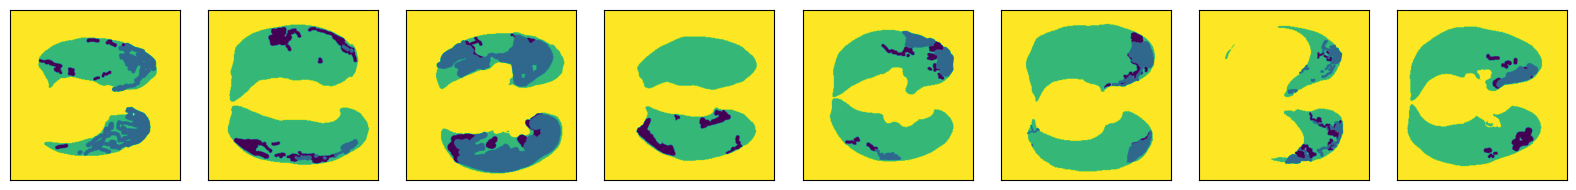

In [9]:
def onehot_to_mask(mask, palette):
    """
    Convierte una máscara codificada one-hot (H, W, K) a una máscara con una paleta de colores (H, W, C).
    """
    # Encuentra el índice del valor máximo a lo largo del eje de canales, para convertir de one-hot a clase
    x = np.argmax(mask, axis=-1)

    # Convierte los índices de las clases en colores usando la paleta
    colour_codes = np.array(palette)

    # Asigna los colores correspondientes a la máscara
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    return x

# Paleta de colores que mapea las clases a valores [0, 1, 2, 3]
palette = [[0], [1], [2], [3]]

# Convierte las máscaras de one-hot encoding a formato paleteado
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)

# Imprime las dimensiones de las máscaras antes y después de la versión
print('Hot encoded mask size: ', masks_radiopedia.shape)
print('Paletted mask size:', masks_medseg_recover.shape)

# Visualiza las máscaras convertidas (no codificadas en one-hot)
visualize(masks_medseg_recover[30:], hot_encode=False)

La función preprocess_images limita los valores de los píxeles de las imágenes entre -1500 y 500 para manejar valores atípicos. Luego, calcula los percentiles 5 y 95 para filtrar los valores relevantes y, finalmente, normaliza las imágenes usando la media y desviación estándar calculadas. Esto es crucial para que el modelo pueda entrenarse de manera eficiente.

In [10]:
def preprocess_images(images_arr, mean_std=None):
    # Limita los valores de los píxeles entre -1500 y 500
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500

    # Calcula los percentiles 2 y 98 de los valores válidos de los píxeles
    min_perc, max_perc = np.percentile(images_arr, 2), np.percentile(images_arr, 98)

    # Filtra los valores válidos entre esos percentiles
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]

    # Calcula la media y la desviación estándar si no se ha proporcionado
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std

    # Normaliza la imagen utilizando la media y desviación estándar
    images_arr = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')

    return images_arr, (mean, std)

# Preprocesa las imágenes ajustando los valores de píxeles y normalizándolos
images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std)

mean -443.69677734375, std 477.906005859375
mean -443.69677734375, std 477.906005859375
mean -443.69677734375, std 477.906005859375


Los resultados muestran una media de -451.65 y una desviación estándar de 458.57 en los valores de los píxeles de las imágenes de tomografía computarizada (CT), lo cual es consistente en los conjuntos de datos procesados. Esto indica que, en promedio, los píxeles representan tejidos de baja densidad, como los pulmones. La desviación estándar refleja la variabilidad en las densidades de los tejidos presentes en las imágenes. Esta normalización asegura que todas las imágenes se ajusten a un rango común, facilitando un entrenamiento más eficiente y estable del modelo de segmentación.

Lo que hacemos a continuación es generar los histogramas de los valores de los píxeles de las imágenes preprocesadas, permitiendo comparar la distribución de los valores de las imágenes de MedSeg y Radiopedia. Esto es útil para verificar que el preprocesamiento ha normalizado las imágenes correctamente y que los valores de píxeles están en el rango esperado.

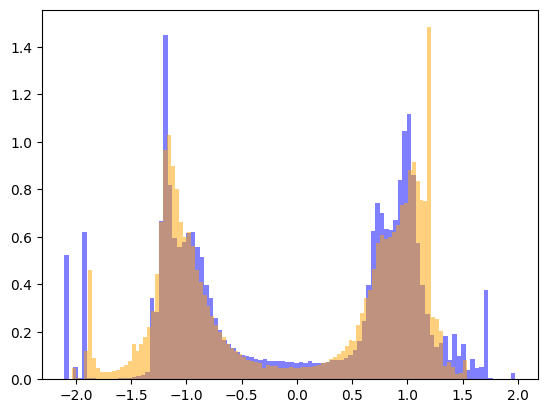

In [11]:
def plot_hists(images1, images2=None):
    # Grafica el histograma de la distribución de valores de las imágenes
    plt.hist(images1.ravel(), bins=100, density=True, color='b', alpha=1 if images2 is None else 0.5)

    # Si se proporcionan dos conjuntos de imágenes, grafica ambos en el mismo histograma
    if images2 is not None:
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')
    plt.show()

# Grafica los histogramas de las imágenes preprocesadas
plot_hists(test_images_medseg, images_radiopedia)

Aquí dividimos los datos en conjuntos de entrenamiento y validación. Los primeros 24 ejemplos de MedSeg se utilizan como conjunto de validación, mientras que el resto de MedSeg y todo el conjunto de Radiopedia se utilizan para el entrenamiento. Combinar ambos conjuntos ayuda a mejorar la robustez del modelo. También al final eliminamos ciertas variables para liberar espacio en la memoria.

In [12]:
# Convertir máscaras nuevamente a su formato de colores
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()

# Dividir los índices de las imágenes en conjuntos de validación y entrenamiento
val_indexes, train_indexes = list(range(24)), list(range(24, 100))

# Combina imágenes y máscaras de diferentes conjuntos para entrenamiento
train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg_recover[train_indexes], masks_radiopedia_recover))

# Asigna los conjuntos de validación
val_images = images_medseg[val_indexes]
val_masks = masks_medseg_recover[val_indexes]

# Tamaño del batch igual al número de máscaras de validación
batch_size = len(val_masks)

# Elimina variables grandes de la memoria para liberar espacio
del masks_medseg_recover
del masks_radiopedia_recover
del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg

Definimos augmentaciones para el conjunto de entrenamiento y validación. Para el entrenamiento, utilizamos rotación, recorte aleatorio y volteo horizontal, lo que ayuda a aumentar la variabilidad de los datos y mejorar la generalización del modelo. Para la validación, solo redimensionamos las imágenes para garantizar que estén en el formato correcto.

In [13]:
import tensorflow
import albumentations
import cv2

# Dimensiones de origen y destino para las transformaciones de las imágenes
SOURCE_SIZE = 512
TARGET_SIZE = 256

# Definición de las augmentaciones para el conjunto de entrenamiento
train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE),
                                   TARGET_SIZE,
                                   TARGET_SIZE,
                                   interpolation=cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),
])

# Augmentaciones para el conjunto de validación (solo redimensionar)
val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

Definimos una clase personalizada llamada Dataset para manejar las imágenes y las máscaras. Esta clase permite cargar los datos, aplicar augmentaciones (si están definidas) y normalizarlas antes de alimentar el modelo. Convierte tanto las imágenes como las máscaras en tensores de PyTorch, que es el formato que el modelo necesita para entrenar.

In [14]:
from PIL import Image
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import time

from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import torch

# Si les da error en esta linea, cambiar el entorno de ejecucion a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Clase Dataset personalizada para cargar imágenes y máscaras
class Dataset:
    def __init__(self, images, masks, augmentations=None):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
        self.mean = [0.485]
        self.std = [0.229]

    def __getitem__(self, i):
        # Cargar una imagen y su máscara correspondiente
        image = self.images[i]
        mask = self.masks[i]

        # Aplicar augmentaciones si están definidas
        if self.augmentations is not None:
            sample = self.augmentations(image=image, mask=mask)
            image, mask = Image.fromarray(np.squeeze(sample['image'], axis=2)), sample['mask']

        if self.augmentations is None:
            image = Image.fromarray(image)

        # Convertir la imagen a un tensor y normalizarla
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)

        # Convertir la máscara a un tensor largo
        mask = torch.from_numpy(mask).long()

        return image, mask

    def __len__(self):
        # Retorna el número total de imágenes en el conjunto
        return len(self.images)

    def tiles(self, image, mask):
        # Divide una imagen y su máscara en parches más pequeños
        img_patches = image.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches = img_patches.contiguous().view(3, -1, 512, 768)
        img_patches = img_patches.permute(1, 0, 2, 3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

# Crear datasets de entrenamiento y validación
train_dataset = Dataset(train_images, train_masks, train_augs)
val_dataset = Dataset(val_images, val_masks, val_augs)

# Crear DataLoaders para el entrenamiento y validación
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

cuda


Se crean los DataLoaders tanto para el conjunto de entrenamiento como para el de validación. Estos DataLoaders son los que alimentarán al modelo con lotes de datos durante el entrenamiento. En la creación de los DataLoaders usamos shuffle = True, esto asegura que el conjunto de entrenamiento se mezcle antes de cada época, lo que es importante para que el modelo no se sesgue hacia un orden particular de las muestras.

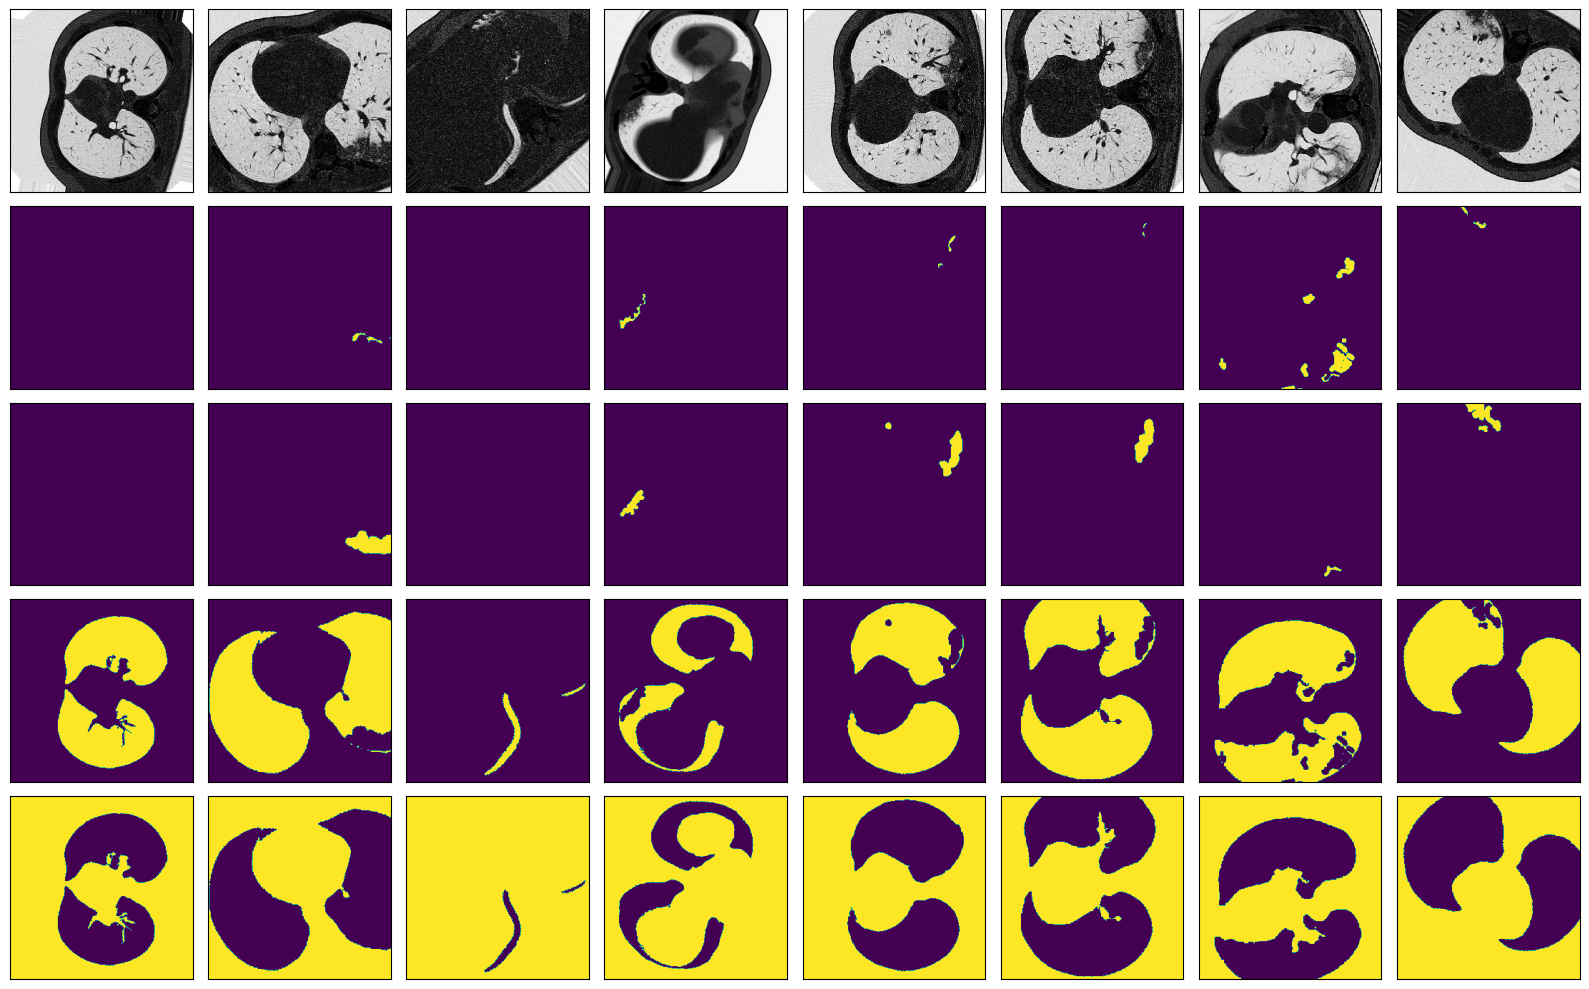

In [15]:
def mask_to_onehot(mask, palette):
    """
    Convierte una máscara de segmentación (H, W, C) a una representación one-hot (H, W, K),
    donde K es el número de clases y C representa el número de canales (1 o 3). Devuelve un tensor one-hot.
    """
    semantic_map = []
    for colour in palette:
        # Comprueba si cada píxel de la máscara coincide con un color en la paleta.
        equality = np.equal(mask, colour)
        # Genera un mapa binario por clase, donde se marcan los píxeles que coinciden con el color.
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)

    # Apila todos los mapas de clase y los convierte a tipo float32.
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    # Convierte el mapa semántico a un tensor de PyTorch.
    return torch.from_numpy(semantic_map)

# Obtener el primer lote de datos del dataloader.
i, train_data = next(enumerate(train_dataloader))

# Convierte la máscara del dataset en un tensor one-hot usando la paleta de colores.
mask_hot_encoded = mask_to_onehot(torch.unsqueeze(train_data[1], -1).numpy(), palette)

# Visualiza la imagen original y la máscara codificada en one-hot.
visualize(train_data[0].permute(0, 2, 3, 1), mask_hot_encoded)

La función pixel_accuracy mide qué tan bien el modelo está clasificando correctamente los píxeles. Aplica softmax a la salida del modelo para convertirla en probabilidades, luego selecciona la clase con mayor probabilidad para cada píxel y compara esas predicciones con la verdad de terreno (ground truth) representada por la máscara. Finalmente, calcula la precisión como el porcentaje de píxeles correctamente clasificados.

In [16]:
def pixel_accuracy(output, mask):
    """
    Calcula la precisión de los píxeles comparando la salida del modelo con la máscara real.
    """
    with torch.no_grad():
        # Aplica softmax y luego toma la clase con mayor probabilidad.
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        # Compara los píxeles predichos con los reales.
        correct = torch.eq(output, mask).int()
        # Calcula la precisión como el ratio de píxeles correctos sobre el total.
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

La función mIoU mide el rendimiento del modelo en segmentación de imágenes para múltiples clases, devolviendo el promedio del IoU de todas las clases presentes en la imagen. Esto es útil en tareas donde el modelo tiene que segmentar varias regiones, como en el caso de las imágenes médicas con diferentes tipos de tejidos o afectaciones (ground-glass, consolidations, etc.).

In [17]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    """
    Calcula el IoU medio para todas las clases. Es una métrica que mide la intersección sobre la unión
    entre la predicción y la máscara real.
    """
    with torch.no_grad():
        # Aplica softmax para obtener probabilidades, luego selecciona la clase más probable.
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        # Itera sobre cada clase para calcular IoU por clase.
        for clas in range(0, n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:  # Si no hay píxeles para esta clase.
                iou_per_class.append(np.nan)
            else:
                # Calcula la intersección y la unión.
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                # Calcula el IoU usando intersección sobre unión.
                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        # Devuelve la media de IoU por clase, ignorando NaN.
        return np.nanmean(iou_per_class)

La función IoU calcula la intersección sobre la unión entre la predicción y la verdad de terreno para una única imagen o clase. Se utiliza comúnmente en segmentación binaria o para analizar la precisión del modelo en una sola clase. Es útil cuando queremos observar el rendimiento del modelo en un caso específico, sin promediar sobre múltiples clases.

In [18]:
def iou(pred, gt):
    """
    Calcula el IoU entre la predicción y la verdad de terreno (ground truth).
    """
    pred = pred.squeeze().cpu().data.numpy()
    pred = ToLabel(pred)
    gt = gt.squeeze().cpu().data.numpy()
    agg = pred + gt
    i = float(np.sum(agg == 2))  # Intersección.
    u = float(np.sum(agg > 0))   # Unión.
    # Si no hay unión, IoU es 1, de lo contrario se calcula la fracción.
    if u == 0:
        result = 1
    else:
        result = i / u
    return result

## Construcción del modelo.

In [19]:
# Definición del modelo U-Net usando EfficientNet como backbone.
model = smp.Unet('efficientnet-b2', in_channels=1, encoder_weights='imagenet',
                 classes=4, activation=None, encoder_depth=5,
                 decoder_channels=[256, 128, 64, 32, 16])
#decoder_attention_type ='scse'

### Arquitectura del Modelo: U-Net con EfficientNet-b2
El modelo que estamos utilizando es una variante de U-Net, una arquitectura muy utilizada para tareas de segmentación de imágenes. La característica clave de U-Net es su estructura simétrica en forma de U, que consta de dos caminos principales:

* Encoder: Extrae características de bajo nivel de las imágenes (p.ej., bordes, texturas) y las transforma en representaciones más abstractas y comprimidas.

* Decoder: Reconstruye la imagen a su resolución original, aprovechando tanto las características de bajo nivel como las de alto nivel.

La versión de U-Net que estamos utilizando tiene algunas modificaciones importantes:

1. Backbone EfficientNet-b2: EfficientNet es una arquitectura eficiente para la extracción de características, y su variante b2 es un buen balance entre eficiencia computacional y precisión. Este backbone es preentrenado en ImageNet, lo que significa que ya ha aprendido a detectar características útiles en imágenes generales. Al usar EfficientNet, nuestro modelo puede aprovechar estas características preentrenadas y ajustarlas a las particularidades del conjunto de datos de COVID-19.

2. In_channels=1: Esto indica que las imágenes de entrada tienen un solo canal, ya que son imágenes en escala de grises (tomografías computarizadas de los pulmones).

3. Classes=4: El modelo predice cuatro clases, correspondientes a las diferentes regiones que queremos segmentar en las tomografías:

    * Clase 0: Ground-glass opacities
    * Clase 1: Consolidations
    * Clase 2: Lungs other
    * Clase 3: Background

4. Encoder Depth=5: El encoder tiene cinco capas de convolución, lo que permite al modelo capturar características en múltiples escalas, desde las más finas hasta las más globales.

5. Decoder Channels: El decodificador utiliza canales de diferentes tamaños para reconstruir la imagen de forma progresiva: 256, 128, 64, 32, 16. Estos son los tamaños de los canales de salida de cada capa en el decoder. Comienzan con más canales para captar características complejas y se reducen gradualmente para producir una máscara segmentada final.

#### Justificación de la Elección del Modelo:

El modelo U-Net con EfficientNet-b2 como backbone es una opción excelente para esta tarea de segmentación de imágenes médicas debido a varias razones:

U-Net es conocido por su capacidad de segmentar con precisión imágenes con estructuras complejas, como los pulmones y las áreas afectadas por COVID-19.
EfficientNet-b2 ofrece un equilibrio entre rendimiento y costo computacional, permitiendo que el modelo sea más eficiente y rápido sin sacrificar precisión.
La pre-entrenación en ImageNet le permite al modelo aprovechar características generales ya aprendidas y adaptarlas a nuestro conjunto de datos específico con menos ajustes.

#### Comparación con Otras Arquitecturas:
Podríamos haber optado por arquitecturas como ResNet o VGG como backbone, pero EfficientNet ofrece una mejor relación precisión-eficiencia, lo cual es especialmente importante cuando se trabaja con imágenes médicas de alta resolución y grandes volúmenes de datos. Además, EfficientNet tiene un diseño optimizado para obtener buenos resultados con menos parámetros, lo que lo hace adecuado para aplicaciones prácticas.

# Entrenamiento del modelo

In [20]:
def get_lr(optimizer):
    """
    Devuelve la tasa de aprendizaje actual del optimizador.
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    """
    Entrena el modelo a través de múltiples épocas. Monitorea las métricas como pérdida, IoU, y precisión.
    Guarda el modelo si la pérdida de validación mejora.
    """
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf  # Mejor pérdida hasta el momento.
    decrease = 1; not_improve = 0

    model.to(device)
    fit_time = time.time()

    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0

        model.train()  # Fase de entrenamiento.
        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data
            image = image_tiles.to(device); mask = mask_tiles.to(device)

            # Forward pass.
            output = model(image)
            loss = criterion(output, mask)

            # Cálculo de métricas.
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            # Backpropagation y optimización.
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Actualización de la tasa de aprendizaje.
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:  # Validación después de cada época.
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0

            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data
                    image = image_tiles.to(device); mask = mask_tiles.to(device)
                    output = model(image)

                    # Métricas en la fase de validación.
                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            # Almacena las pérdidas promedio de entrenamiento y validación.
            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(val_loader))

            # Guarda el modelo si la pérdida de validación mejora.
            if min_loss > (test_loss / len(val_loader)):
                print(f'Loss Decreasing.. {min_loss:.3f} >> {(test_loss/len(val_loader)):.3f}')
                min_loss = (test_loss / len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, f'Unet_efficientnet_b2_mIoU-{val_iou_score/len(val_loader):.3f}.pt')

            # Si la pérdida no mejora, cuenta cuántas veces no ha mejorado.
            if (test_loss / len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss / len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                # Este hiperparametro lo podemos aumentar para ver si el modelo mejora despues de 7 veces que no decrementa el loss. A lo mejor decrementa despues de 7 iteraciones
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            # Registro de IoU y precisión.
            val_iou.append(val_iou_score / len(val_loader))
            train_iou.append(iou_score / len(train_loader))
            train_acc.append(accuracy / len(train_loader))
            val_acc.append(test_accuracy / len(val_loader))
            print(f"Epoch:{e+1}/{epochs}..",
                  f"Train Loss: {running_loss/len(train_loader):.3f}..",
                  f"Val Loss: {test_loss/len(val_loader):.3f}..",
                  f"Train mIoU:{iou_score/len(train_loader):.3f}..",
                  f"Val mIoU: {val_iou_score/len(val_loader):.3f}..",
                  f"Train Acc:{accuracy/len(train_loader):.3f}..",
                  f"Val Acc:{test_accuracy/len(val_loader):.3f}..",
                  f"Time: {(time.time()-since)/60:.2f}m")

    # Devuelve el historial de pérdidas, IoU, precisión y tasas de aprendizaje.
    # Esto más que nada nos ayuda para ver cómo han ido cambiando nuestras variables
    # con cada epoch de entrenamiento
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

La función fit es el núcleo del proceso de entrenamiento. Se encarga de entrenar el modelo durante múltiples épocas, monitorizando métricas como la pérdida, el IoU (Intersection over Union) y la precisión. También guarda el modelo si la pérdida en el conjunto de validación mejora. La función fit cuenta con los siguientes pasos:

1. Se inicializan listas para almacenar las pérdidas, mIoU, precisión y la tasa de aprendizaje a lo largo del entrenamiento.

2. El modelo se entrena durante un número determinado de épocas (en este caso, 20). En cada época, se realiza la propagación hacia adelante (forward pass) para obtener la salida del modelo, se calcula la pérdida y se actualizan los pesos del modelo mediante backpropagation.

3. Se calculan métricas importantes como el IoU medio (mIoU) y la precisión a nivel de píxel. Esto se hace tanto para los datos de entrenamiento como para los datos de validación.

4. Después de calcular la pérdida, se realiza backpropagation para actualizar los pesos del modelo. Esto se hace llamando a loss.backward() y luego optimizando los parámetros con el optimizador AdamW. También se actualiza la tasa de aprendizaje utilizando el scheduler OneCycleLR.

5. Después de cada época, se evalúa el modelo en el conjunto de validación. Las métricas calculadas durante la fase de validación son almacenadas y comparadas con las del entrenamiento.

6. Si la pérdida en el conjunto de validación mejora, el modelo se guarda automáticamente. Este proceso permite guardar el mejor modelo obtenido durante el entrenamiento.

7. Si la pérdida no mejora después de 7 épocas consecutivas, el entrenamiento se detiene automáticamente para evitar un ajuste innecesario del modelo.

8. Al final de cada época, se guarda el historial de la pérdida, el mIoU y la precisión tanto para el conjunto de entrenamiento como para el conjunto de validación. Este historial es útil para analizar el progreso del modelo.

In [21]:
# Valor máximo del learning rate
max_lr = 1e-3
# Número de epochs
epoch = 20
# Penalización de regularización (esto nos ayuda para evitar el overfitting)
weight_decay = 1e-4

# Función de pérdida. Elegimos CrossEntropy porque es la que comúnmente se usa para
# problemas de clasificación
criterion = nn.CrossEntropyLoss()

# Optimizador AdamW para agregarle el weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)

# Scheduler para ajustar dinámicamente la tasa de aprendizaje durante el entrenamiento.
# Se utiliza OneCycleLR, que ajusta el learning rate entre un valor bajo y el máximo especificado
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))

# Aqui se entrena el modelo y guardamos el historial del mismo en una variable para graficar
# los resultados de las variables (loss, score, accuracy, etc) después.
# Le pasamos los conjuntos de train y validation como parámetros, así como la función de
# pérdida, el optimizador AdamW y el Scheduler.
history = fit(epoch, model, train_dataloader, val_dataloader, criterion, optimizer, sched)

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.435
Epoch:1/20.. Train Loss: 1.511.. Val Loss: 2.435.. Train mIoU:0.126.. Val mIoU: 0.119.. Train Acc:0.307.. Val Acc:0.274.. Time: 0.25m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 2.435 >> 0.920
Epoch:2/20.. Train Loss: 0.896.. Val Loss: 0.920.. Train mIoU:0.346.. Val mIoU: 0.338.. Train Acc:0.730.. Val Acc:0.757.. Time: 0.18m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.920 >> 0.430
Epoch:3/20.. Train Loss: 0.387.. Val Loss: 0.430.. Train mIoU:0.502.. Val mIoU: 0.472.. Train Acc:0.960.. Val Acc:0.911.. Time: 0.18m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.430 >> 0.391
saving model...
Epoch:4/20.. Train Loss: 0.153.. Val Loss: 0.391.. Train mIoU:0.558.. Val mIoU: 0.538.. Train Acc:0.975.. Val Acc:0.921.. Time: 0.18m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.391 >> 0.354
Epoch:5/20.. Train Loss: 0.102.. Val Loss: 0.354.. Train mIoU:0.594.. Val mIoU: 0.475.. Train Acc:0.977.. Val Acc:0.885.. Time: 0.17m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.354 >> 0.245
Epoch:6/20.. Train Loss: 0.080.. Val Loss: 0.245.. Train mIoU:0.599.. Val mIoU: 0.556.. Train Acc:0.978.. Val Acc:0.929.. Time: 0.17m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:7/20.. Train Loss: 0.064.. Val Loss: 0.248.. Train mIoU:0.615.. Val mIoU: 0.550.. Train Acc:0.981.. Val Acc:0.925.. Time: 0.17m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.248 >> 0.235
Epoch:8/20.. Train Loss: 0.057.. Val Loss: 0.235.. Train mIoU:0.623.. Val mIoU: 0.559.. Train Acc:0.982.. Val Acc:0.929.. Time: 0.17m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.235 >> 0.210
Epoch:9/20.. Train Loss: 0.055.. Val Loss: 0.210.. Train mIoU:0.624.. Val mIoU: 0.569.. Train Acc:0.981.. Val Acc:0.937.. Time: 0.17m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:10/20.. Train Loss: 0.049.. Val Loss: 0.230.. Train mIoU:0.633.. Val mIoU: 0.557.. Train Acc:0.983.. Val Acc:0.935.. Time: 0.17m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.230 >> 0.218
saving model...
Epoch:11/20.. Train Loss: 0.046.. Val Loss: 0.218.. Train mIoU:0.634.. Val mIoU: 0.566.. Train Acc:0.983.. Val Acc:0.936.. Time: 0.17m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.218 >> 0.200
Epoch:12/20.. Train Loss: 0.045.. Val Loss: 0.200.. Train mIoU:0.641.. Val mIoU: 0.572.. Train Acc:0.984.. Val Acc:0.938.. Time: 0.17m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.200 >> 0.194
Epoch:13/20.. Train Loss: 0.045.. Val Loss: 0.194.. Train mIoU:0.645.. Val mIoU: 0.569.. Train Acc:0.983.. Val Acc:0.937.. Time: 0.17m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.194 >> 0.194
Epoch:14/20.. Train Loss: 0.043.. Val Loss: 0.194.. Train mIoU:0.642.. Val mIoU: 0.571.. Train Acc:0.984.. Val Acc:0.938.. Time: 0.17m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.194 >> 0.194
Epoch:15/20.. Train Loss: 0.042.. Val Loss: 0.194.. Train mIoU:0.645.. Val mIoU: 0.578.. Train Acc:0.984.. Val Acc:0.940.. Time: 0.17m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.194 >> 0.187
saving model...
Epoch:16/20.. Train Loss: 0.042.. Val Loss: 0.187.. Train mIoU:0.642.. Val mIoU: 0.578.. Train Acc:0.984.. Val Acc:0.940.. Time: 0.19m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:17/20.. Train Loss: 0.041.. Val Loss: 0.192.. Train mIoU:0.646.. Val mIoU: 0.577.. Train Acc:0.985.. Val Acc:0.940.. Time: 0.18m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:18/20.. Train Loss: 0.040.. Val Loss: 0.193.. Train mIoU:0.651.. Val mIoU: 0.580.. Train Acc:0.985.. Val Acc:0.940.. Time: 0.19m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.193 >> 0.193
Epoch:19/20.. Train Loss: 0.039.. Val Loss: 0.193.. Train mIoU:0.649.. Val mIoU: 0.577.. Train Acc:0.985.. Val Acc:0.940.. Time: 0.18m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.193 >> 0.192
Epoch:20/20.. Train Loss: 0.039.. Val Loss: 0.192.. Train mIoU:0.653.. Val mIoU: 0.577.. Train Acc:0.985.. Val Acc:0.940.. Time: 0.18m
Total time: 3.57 m


### Proceso de entrenamiento

En esta sección se describe cómo se entrena el modelo U-Net utilizando EfficientNet-b2 como backbone, con los detalles clave del proceso. Se entrenó el modelo durante 20 épocas, utilizando un tamaño de batch de 16 imágenes por iteración. Este tamaño de batch fue elegido por el balance entre la capacidad computacional y la estabilidad en el entrenamiento. El entrenamiento se llevó a cabo mediante la función fit (detallada arriba), que calcula la pérdida en cada lote de entrenamiento, actualiza los pesos del modelo utilizando backpropagation, y evalúa el modelo en el conjunto de validación después de cada época. Las métricas de evaluación se grafican posteriormente para monitorear el rendimiento. 

A continuación, se detallan los componentes clave involucrados en el entrenamiento:

1. Se usó una función de pérdida (criterion) con Cross Entropy Loss, la cual es adecuada para problemas de clasificación multicategoría, como la segmentación de imágenes donde el modelo necesita distinguir entre varias clases.  Esta es la función que mide qué tan bien el modelo está realizando sus predicciones comparado con los valores reales. El objetivo del entrenamiento es minimizar esta pérdida. La elección de esta función se debe a su capacidad para penalizar fuertemente las predicciones incorrectas y es la opción comúnmente utilizada en problemas de segmentación de imágenes.

2. Para ajustar la tasa de aprendizaje de usó un Scheduler (planificador de aprendizaje). Un scheduler ajusta la tasa de aprendizaje (learning rate) durante el entrenamiento. El optimizador dentro el Scheduler es AdamW, que es una variación del optimizador Adam, con la inclusión de un decaimiento del peso (weight decay) para regularizar el modelo y evitar el sobreajuste. El optimizador es el algoritmo que ajusta los pesos del modelo para minimizar la función de pérdida. Por otro lado, el weight decay es una técnica de regularización que agrega una penalización a la magnitud de los pesos en el modelo, ayudando a evitar que el modelo se ajuste demasiado a los datos de entrenamiento (overfitting). Esta penalización se suma a la función de pérdida, lo que incentiva al modelo a mantener los pesos más pequeños y simplificar las soluciones. Para el ajuste de la tasa de aprendizaje, se usa directamente OneCycleLR. Esta una técnica de ajuste de tasa de aprendizaje donde se comienza con una tasa baja, se incrementa hasta un valor máximo durante la primera mitad del entrenamiento, y luego se reduce de nuevo a un valor bajo. Esto puede mejorar la convergencia del modelo y evitar quedarse atrapado en mínimos locales.

3. Durante el entrenamiento, se monitorearon continuamente métricas como la pérdida (loss), la precisión (accuracy) y el mIoU (mean Intersection over Union). Como se mencionó anteriormente, si la pérdida en el conjunto de validación mejoraba, el modelo se guardaba. Si no mejoraba después de siete épocas consecutivas, el entrenamiento se detenía.


# Resultados

In [22]:
# Guardamos el modelo en un archivo
torch.save(model, 'Unet-efficientnet.pt')


El siguiente código define tres funciones para graficar los resultados del entrenamiento y validación del modelo, específicamente los valores de pérdida (loss), precisión (accuracy) y puntuación de mean Intersection over Union (mIoU) por cada epoch. La interpretación y la importancia de graficar estos resultados son cruciales para evaluar el rendimiento del modelo. A continuación te explico la relevancia de cada gráfico:

1. Graficar el Loss (pérdida):
   - La función plot_loss compara la pérdida del modelo durante el entrenamiento (train_loss) y la validación (val_loss) a lo largo de cada *epoch*.
   - **Importancia:**
     - La pérdida indica qué tan mal está haciendo el modelo en cada *epoch*.
     - Al observar la curva de pérdida, puedes detectar si el modelo está aprendiendo correctamente o si está sobreajustando (overfitting). Por ejemplo, si la pérdida en el conjunto de validación aumenta mientras que la del entrenamiento disminuye, esto podría ser una señal de sobreajuste.
     - Ayuda a identificar problemas en el entrenamiento, como una tasa de aprendizaje muy alta o baja.

2. Graficar el Score de mIoU:
   - La función `plot_score grafica el puntaje mean Intersection over Union (mIoU) para el conjunto de entrenamiento y validación en cada epoch.
   - **Importancia:**
     - mIoU es una métrica clave en segmentación semántica, ya que mide la superposición entre las predicciones del modelo y las etiquetas reales de cada clase. Un mayor valor de mIoU indica que el modelo está haciendo un mejor trabajo segmentando correctamente las imágenes.
     - Comparar el mIoU de entrenamiento y validación permite evaluar si el modelo generaliza bien o si está siendo demasiado optimista con el conjunto de entrenamiento.

3. Graficar la Accuracy (precisión):
   - La función plot_acc grafica la precisión del modelo, es decir, la proporción de predicciones correctas, tanto para entrenamiento (train_acc) como para validación (val_acc).
   - **Importancia:**
     - La precisión es una métrica general para evaluar qué tan bien el modelo está clasificando cada píxel en la imagen de forma correcta.
     - Ver cómo varía la precisión entre el conjunto de entrenamiento y el de validación puede ayudarte a entender si el modelo está siendo consistente o si hay problemas como sobreajuste.

In [23]:
# Funciones para graficar los resultados del modelo entrenado
# Función para graficar la pérdida por epoch (Train vs Validation)
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

# Función para graficar el puntaje por epoch (Train vs Validation)
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

# Función para graficar la precisión por epoch (Train vs Validation)
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

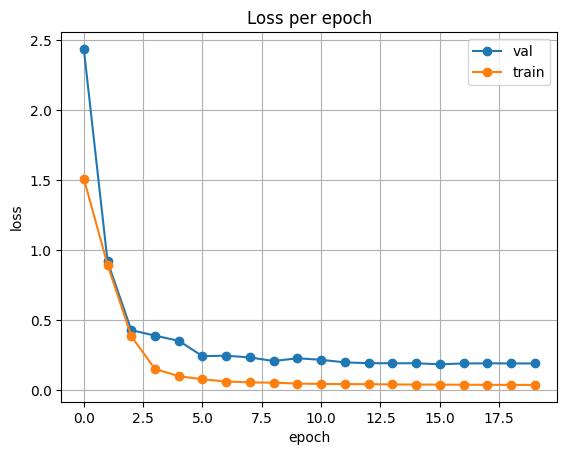

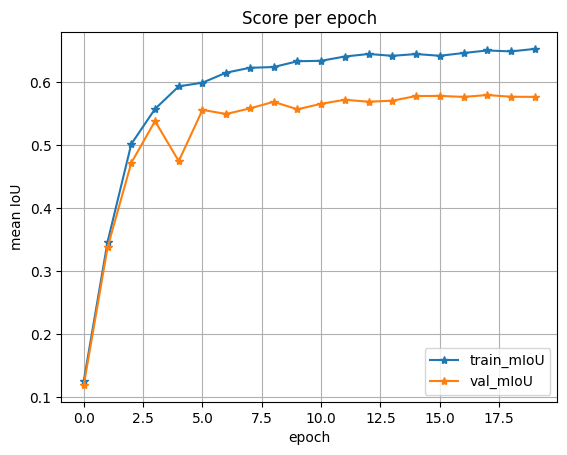

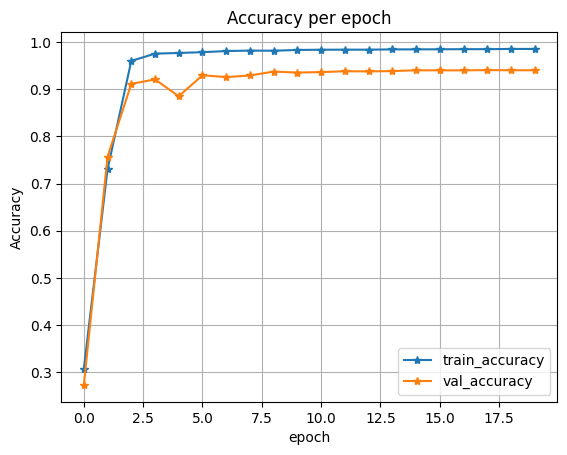

In [24]:
plot_loss(history)
plot_score(history)
plot_acc(history)

### 1. **Pérdida (Loss) por epoch**
   - **Interpretación del gráfico:**
     - Al inicio (primeras épocas), la pérdida para ambos conjuntos (entrenamiento y validación) es alta, lo cual es normal ya que el modelo aún está aprendiendo.
     - A medida que avanzan las épocas, la pérdida de entrenamiento (train_loss) disminuye rápidamente, lo que indica que el modelo está ajustándose mejor a los datos.
     - Sin embargo, la pérdida de validación (val_loss) no disminuye tanto como la de entrenamiento y se estabiliza después de la cuarta época, lo que sugiere que el modelo empieza a tener un rendimiento estable en los datos de validación.
     - El hecho de que la pérdida de entrenamiento sea menor que la de validación podría ser una señal de **ligero sobreajuste**, aunque no es muy grave ya que ambas curvas se estabilizan.

### 2. **Puntuación mIoU por epoch**
   - **Interpretación del gráfico:**
     - En las primeras épocas, el mIoU tanto para el conjunto de entrenamiento como de validación aumenta rápidamente, lo que indica que el modelo está mejorando su capacidad para segmentar correctamente las imágenes.
     - El mIoU del entrenamiento sigue aumentando a un ritmo más rápido que el de validación, llegando a un puntaje más alto, lo cual podría ser una señal de que el modelo se está ajustando mejor a los datos de entrenamiento.
     - El mIoU del conjunto de validación se estabiliza alrededor de la cuarta época, sugiriendo que el modelo ha alcanzado un punto de rendimiento estable en datos no vistos, aunque sigue siendo menor que en el conjunto de entrenamiento. Esto podría ser indicativo de **overfitting**, ya que el modelo parece ajustarse mejor a los datos de entrenamiento.

### 3. **Precisión (Accuracy) por epoch**
   - **Interpretación del gráfico:**
     - Al principio, la precisión de entrenamiento y validación son bajas, pero ambas aumentan significativamente durante las primeras épocas, alcanzando un rendimiento alto rápidamente.
     - La precisión de entrenamiento se estabiliza cerca del 100%, lo que indica que el modelo está clasificando correctamente casi todos los píxeles en el conjunto de entrenamiento.
     - La precisión en el conjunto de validación, aunque es alta (mayor del 90%), es menor que la de entrenamiento, lo que refuerza la idea de un posible **sobreajuste**, ya que el modelo parece estar aprendiendo mejor en los datos de entrenamiento que en los de validación.

# EVALUACIÓN

In [25]:
# Función para predecir la máscara de una imagen y calcular la métrica mIoU
def predict_image_mask_miou(model, image, mask, mean=[0.485], std=[0.229]):
    # Establecer el modelo en modo de evaluación
    model.eval()
    #t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    #image = t(image)
    # Enviar el modelo y las imágenes a la GPU
    model.to(device); image=image.to(device)
    mask = mask.to(device)

    # Desactivar el cálculo de los gradientes, ya que en esta fase no queremos
    # optimizar el modelo sino evaluarlo
    with torch.no_grad():

        #image = image.unsqueeze(0)
        #mask = mask.unsqueeze(0)

        # Obtener la predicción del modelo para la imagen dada
        output = model(image)
        # Obtener la forma de salida (batch size, canales, altura, anchura)
        a, b, c, d = output.shape
        # Calcular el puntaje de IoU medio (mIoU) para la predicción y la máscara real
        score = mIoU(output, mask)
        # Obtener la máscara predicha: argmax selecciona la clase con mayor probabilidad para cada pixel
        masked = torch.argmax(output, dim=1)
        # Mover la máscara a la CPU y eliminar el batch dimension
        masked = masked.cpu().squeeze(0)
    # Devolver la máscara predicha, el puntaje mIoU, y la salida original del modelo
    return masked, score, output.permute(0, 2, 3,1)

A continuación se muestran las funciones que se usaron para la evaluación del modelo junto a su explicación. 

**predict_image_mask_pixel()**
   - **Propósito:** Esta función también predice una máscara de segmentación, pero en lugar de calcular el mIoU, calcula la precisión por píxel, es decir, qué porcentaje de los píxeles se clasifican correctamente.
   - **Pasos:**
     1. **Modo de evaluación y cálculo sin gradientes:** Igual que en la función anterior, el modelo se pone en modo de evaluación y se desactiva el cálculo de gradientes.
     2. **Predicción:** El modelo genera la salida con las probabilidades por clase para cada píxel.
     3. **Cálculo de la precisión por píxel:** Se calcula la precisión a nivel de píxel comparando la predicción con la máscara real, usando la función pixel_accuracy(output, mask).
     4. **Selección de la clase predicha:** De nuevo, se usa torch.argmax(output, dim=1) para seleccionar la clase con mayor probabilidad por píxel.
     5. **Resultado:** La función devuelve la máscara predicha y el valor de la precisión por píxel.

   - **Interpretación:** Esta función es útil para obtener una métrica adicional, la precisión por píxel, que mide cuán bien el modelo clasifica píxel por píxel en comparación con la máscara real.

In [26]:
# Función para predecir la máscara de una imagen y calcular la precisión a nivel de píxel
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Establecer el modelo en modo de evaluación
    model.eval()

    # Mover el modelo, la imagen y la máscara al dispositivo (GPU si está disponible)
    model.to(device); image=image.to(device)
    mask = mask.to(device)

    # Desactivar los gradientes
    with torch.no_grad():

        # Hacemos la predicción
        output = model(image)
        # Se calcula la precisión por píxel entre la máscara predicha y la real
        acc = pixel_accuracy(output, mask)
        # Se selecciona la clase con mayor probabilidad en cada píxel
        masked = torch.argmax(output, dim=1)
        # Mover la máscara a la CPU y eliminar el batch dimension
        masked = masked.cpu().squeeze(0)
    # Devolver la máscara predicha y la precisión por píxel
    return masked, acc

  **mask_to_onehot()**
   - **Propósito:** Convierte una máscara de segmentación (una imagen donde cada píxel tiene un valor que representa su clase) en un formato one-hot encoding, donde cada clase está representada por un vector binario.
   - **Pasos:**
     1. **Iteración sobre la paleta de colores:** Para cada color/clase en la paleta, se comparan los píxeles de la máscara con ese color.
     2. **Creación del mapa de clases:** Se genera un mapa binario donde los píxeles que coinciden con el color actual se marcan como True (1).
     3. **Stack de mapas:** Todos los mapas binarios se apilan para crear una matriz donde cada píxel tiene un vector de longitud igual al número de clases.
     4. **Conversión a tensor:** Finalmente, el mapa se convierte en un tensor de PyTorch para su posterior procesamiento.

   - **Interpretación:** Esta función es clave para convertir las máscaras de segmentación en un formato que puede ser procesado por modelos o para cálculos posteriores, como la visualización de las predicciones.

In [27]:
# Función para convertir una máscara de segmentación en un vector one-hot
def mask_to_onehot(mask, palette):
    """
    Convierte una máscara de segmentación (H, W, C) a (H, W, K), donde el último
    eje es un vector one-hot encoding. K es el número de clases.
    """
    semantic_map = []
    # Iterar sobre los colores en la paleta de clases
    for colour in palette:
        # Comparar cada píxel de la máscara con el color actual
        equality = np.equal(mask, colour)
        # Crear un mapa de clase donde coinciden los colores
        class_map = np.all(equality, axis=-1)
        # Agregar el mapa de clase a la lista
        semantic_map.append(class_map)
    # Apilar los mapas de clase en el último eje y convertirlos a float
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    # Convertir el mapa semántico a un tensor de PyTorch
    return torch.from_numpy(semantic_map)

**Flujo General del Código**
   - **Entradas:**
     - Se toma un lote de imágenes y máscaras del val_dataloader usando next(iter(val_dataloader)). Estas imágenes no se vieron durante el entrenamiento, lo que permite medir la capacidad del modelo para generalizar a nuevos datos.
   
   - **Predicción y Visualización:**
     1. **Predicción de la máscara:** La máscara predicha y el puntaje mIoU se obtienen llamando a predict_image_mask_miou(model, image, mask).
     2. **Conversión de la máscara:** La máscara real se convierte en formato one-hot para su visualización usando mask_to_onehot().
     3. **Visualización:** Finalmente, se visualizan la imagen, el mapa semántico real y la predicción del modelo con la función visualize().

   - **Evaluación visual y cuantitativa:**
     - El uso de visualizaciones y métricas como el mIoU o la precisión por píxel es esencial para obtener una imagen clara de la calidad de la segmentación, permitiendo tanto ver como cuantificar cuán bien el modelo predice las clases correctas en cada píxel.
     - El mIoU proporciona una métrica robusta para evaluar el rendimiento del modelo, mientras que la visualización permite detectar posibles errores o áreas de mejora en la segmentación.

In [28]:
# Obtener un chunk de imágenes y máscaras del dataloader de validación
image, mask = next(iter(val_dataloader))
# Predecir la máscara
pred_mask, score,output = predict_image_mask_miou(model, image, mask)
# Convertir la máscara real a one-phot encoding usando la paleta de colores definida
semantic_map = mask_to_onehot(torch.unsqueeze(mask,-1).numpy(),palette)

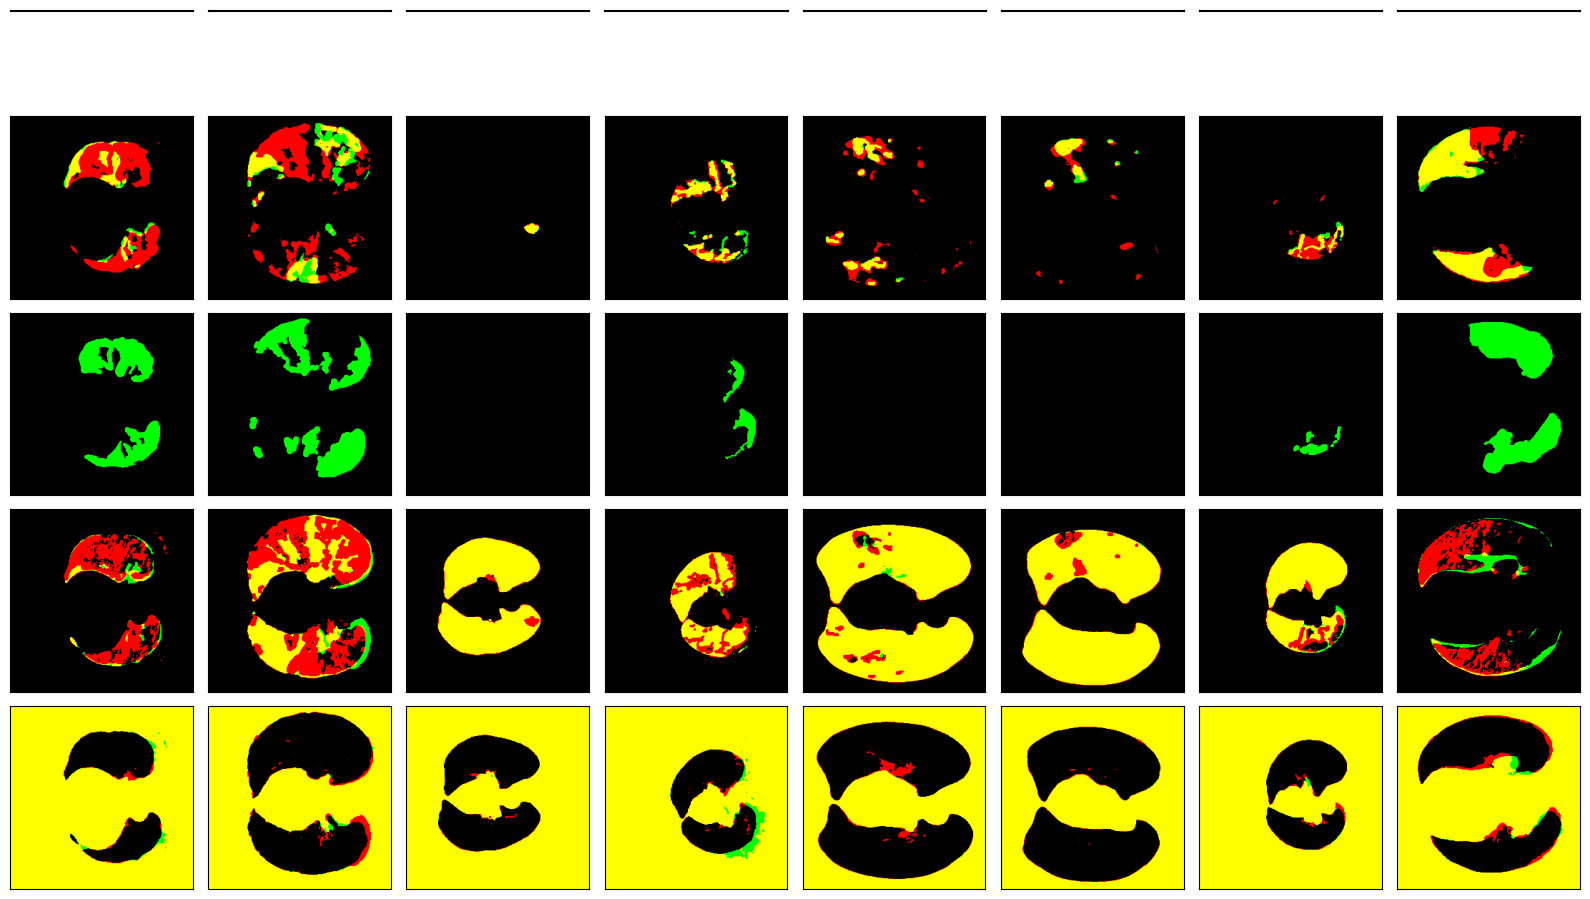

In [29]:
# Visualizar la imagen, el mapa semántico y la predicción del modelo
visualize(image, semantic_map, pred_batch=output)

# Amarillo es Verdadero Positivo (TP), rojo es Falso Positivo (FP), verde es Falso Negativo (FN)

**Función miou_score**:
   - **Propósito**: Calcular el mIoU (mean Intersection over Union) en un conjunto de validación o prueba. Esta métrica es clave en tareas de segmentación semántica, ya que mide la precisión de las predicciones en relación con las máscaras reales (ground truth). El mIoU toma en cuenta la intersección y la unión de las áreas predichas y las verdaderas, lo que proporciona una evaluación más exhaustiva que una simple precisión por píxel.
   - **Flujo**:
     - Se itera sobre el conjunto de prueba utilizando tqdm para mostrar el progreso.
     - Para cada imagen en el lote, se predice la máscara usando el modelo y se calcula el IoU mediante la función predict_image_mask_miou.
     - El IoU calculado se acumula en la lista score_iou, que finalmente devuelve todas las puntuaciones IoU para calcular el mIoU.
   - **Importancia**: Permite medir el rendimiento general del modelo en la segmentación semántica y comparar su eficacia en distintos conjuntos de validación. Esto ayuda a identificar problemas en las predicciones o clases específicas que el modelo no segmenta bien.

In [30]:
# Función para calcular la puntuación mIoU (mean Intersection over Union) en un conjunto de prueba
def miou_score(model, test_set):
  # Lista para almacenar las puntuaciones de IoU
    score_iou = []
    # Iterar sobre el conjunto de prueba (test_set) utilizando tqdm para mostrar el progreso
    for i, data in enumerate(tqdm(test_set)):
        img, mask = data
        # Predecir la máscara y calcular la puntuación mIoU usando la función predict_image_mask_miou
        pred_mask, score,output = predict_image_mask_miou(model, img, mask)
        # Agregar la puntuación de mIoU a la lista
        score_iou.append(score)
    # Devolver los puntajes IoU
    return score_iou

In [31]:
# Calcular la puntuación mIoU del modelo en el conjunto de validación
mob_miou = miou_score(model, val_dataloader)
mob_miou

  0%|          | 0/1 [00:00<?, ?it/s]

[0.5768249295025205]

In [32]:
# Eliminamos las imágenes y máscaras de entrenamiento para liberar memoria
del train_images
del train_masks

**Función test_predict**:
   - **Propósito**: Realizar predicciones con el modelo sobre nuevas imágenes. Convierte la imagen a un tensor, la normaliza, y luego la pasa al modelo para generar una predicción.
   - **Pasos**:
     - Aplica transformaciones a la imagen, como normalización y conversión a tensor.
     - Cambia el modelo a modo de evaluación (model.eval()) para evitar el cálculo de gradientes innecesarios.
     - La predicción se realiza usando torch.no_grad() para ahorrar memoria y evitar el cálculo de gradientes.
     - La salida del modelo pasa por una capa Softmax para obtener las probabilidades de cada clase.
     - El resultado se devuelve en formato NumPy para facilitar su manipulación posterior.
   - **Importancia**: Esta función permite realizar inferencias eficientes sobre nuevas imágenes, lo que es crucial en tareas de validación y pruebas.

In [33]:
def test_predict(model, image, mean=[0.485], std=[0.229]):
    # Composición de transformaciones para la imagen: conversión a tensor y normalización
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    # Aplicar las transformaciones a la imagen
    image = t(image)
    # Establecer el modo evaluacion para train
    model.eval()

    # Mover el modelo y la imagen al GPU
    model.to(device)
    image = image.to(device)

    # Desactivar el cálculo de los gradientes
    with torch.no_grad():
        # Realizar la predicción añadiendo una dimensión a la imagen para el batch
        output = model(torch.unsqueeze(image,1))
        # Aplicamos Softmax para obtener claramente las probabilidades de cada clase
        output = nn.Softmax(dim=1)(output)

    # Mover el resultado a la CPU y convertirlo a NumPy
    return output.permute(0, 2, 3, 1).cpu().numpy()


**Función visualize_final**:
   - **Propósito**: Visualizar imágenes y sus máscaras correspondientes. Permite ver las predicciones del modelo sobre un lote de imágenes con una superposición visual para comparar la imagen original y la predicción de la máscara.
   - **Detalles**:
     - Se visualizan las imágenes originales en escala de grises y, si hay una máscara disponible, se superpone con una opacidad controlada por el parámetro alpha.
   - **Importancia**: La visualización de los resultados es clave en tareas de segmentación para evaluar visualmente la calidad de las predicciones. También, nos permite explicar de una forma más clara dónde es que nuestro modelo está encontrando el ground glass, lo cual aporta muchísimo más contexto al dominio que simplemente mostrar datos cuantitativos.

In [34]:
def visualize_final(image_batch, mask_batch=None, num_samples=8, hot_encode=True, alpha=0.7):
    """
    Visualiza las imágenes originales junto con la máscara superpuesta con una opacidad.
    """
    fig, ax = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))

    for i in range(num_samples):
        ax_image = ax[i]

        # Mostrar la imagen original en escala de grises
        if hot_encode:
            ax_image.imshow(image_batch[i, :, :, 0], cmap='Greys')  
        else:
            ax_image.imshow(image_batch[i, :, :])

        # Si hay una máscara, hacer el overlap con la opacidad (alpha)
        if mask_batch is not None:
            # Usamos solo la primera clase de la máscara
            mask_to_show = mask_batch[i, :, :, 0]
            ax_image.imshow(mask_to_show, cmap='YlOrRd', alpha=alpha)

        # Eliminamos los ticks del eje
        ax_image.set_xticks([])
        ax_image.set_yticks([])

    # Ajustamos el layout para mejorar la visualización
    plt.tight_layout()
    plt.show()

**Predicción y visualización en lote**:
   - **Pasos**:
     - Se crea un lote de imágenes transformadas a partir del conjunto de prueba.
     - La función test_predict se usa para predecir máscaras en un lote de imágenes.
     - Las máscaras se convierten a formato binario usando un umbral de 0.5, lo que significa que cualquier valor por encima de 0.5 se considera clase 1, y debajo, clase 0.
     - Finalmente, se visualizan las imágenes junto con sus máscaras predichas usando la función visualize_final.
   - **Importancia**: Este flujo permite realizar predicciones en lote y visualizar los resultados, lo que es crucial para evaluar el rendimiento del modelo en múltiples imágenes de manera eficiente.

torch.Size([10, 256, 256, 1])
(256, 256, 1)
(10, 256, 256, 4)


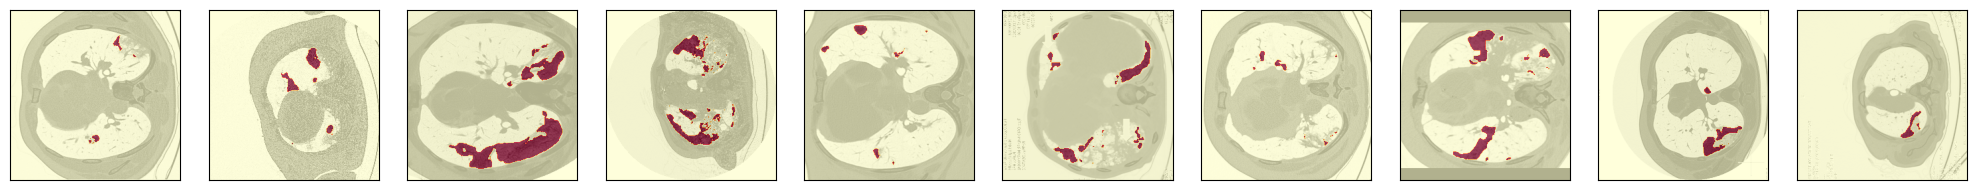

In [35]:
# Crear un batch de imágenes de prueba aplicando las transformaciones de validación
image_batch = np.stack([val_augs(image=img)['image'] for img in test_images_medseg], axis=0)
print(torch.from_numpy(image_batch).shape)
print(image_batch[i].shape)
#output = test_predict(model, torch.from_numpy(image_batch).permute(0, 3, 1,2))
# Inicializar un array para almacenar las predicciones asignadno los valores para el tamaño
# del batch, altura, ancho y canales, respectivamente.
output = np.zeros((10,256,256,4))
# Bucle para realizar predicciones sobre cada imagen en el batch
for i in range(10):
    output[i] = test_predict(model, image_batch[i])
print(output.shape)
# Hacemos las máscaras de predicción de forma binaria (clase 0 o clase 1) con un threshold de 0.5
test_masks_prediction = output > 0.5
# Visualizar las imágenes de prueba junto con las máscaras de predicción
visualize_final(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

### Resumen de los resultados
Como se puede observar en la imagen superior, esas son las predicciones que nuestra red neuronal ha realizado con respecto a encontrar el ground glass que, habiendo estudidado las imágenes y sus máscaras, era la estructura pulmonar que más se encontró en pacientes de COVID-19.

In [36]:
import scipy
# Redimensionar las máscaras predichas a su tamaño original utilizando interpolación
# El factor de ampliación es 2x en las dimensiones espaciales (height, width)
test_masks_prediction_original_size = scipy.ndimage.zoom(test_masks_prediction[..., :-2], (1, 2, 2, 1), order=0)
test_masks_prediction_original_size.shape

(10, 512, 512, 2)

In [37]:
import pandas as pd

# Convertir las máscaras redimensionadas a un archivo CSV
pd.DataFrame(
             data=np.stack((np.arange(len(test_masks_prediction_original_size.ravel())),
                            test_masks_prediction_original_size.ravel().astype(int)),
                            axis=-1),
             columns=['Id', 'Predicted'])\
.set_index('Id').to_csv('sub.csv')

# Conclusión

*Fortalezas del Modelo:*

- El uso de la arquitectura U-Net con EfficientNet-b2 como backbone fue crucial para capturar las características importantes en las imágenes de tomografías computarizadas (CT). El backbone b2 proporcionó un excelente equilibrio entre eficiencia computacional y capacidad de representación, permitiendo un procesamiento más rápido sin sacrificar precisión. Además, el equipo experimentó con EfficientNet-b0 y b4, observando que b2 ofrecía el mejor equilibrio entre rendimiento y costo computacional.

- La implementación de técnicas de preprocesamiento, como la normalización y el cambio de tamaño de las imágenes, contribuyó significativamente a mejorar la calidad del entrenamiento y la estabilidad del modelo. Estos pasos aseguraron que las imágenes fueran homogéneas en términos de dimensiones y valores de pixel, facilitando el aprendizaje del modelo. Asi mismo, elegir un tamaño de batch de 16 fue un punto clave para equilibrar la carga computacional y la estabilidad del modelo. Este tamaño permitió que el entrenamiento fuera eficiente al aprovechar mejor la memoria de la GPU, al tiempo que garantizaba que las actualizaciones de gradientes fueran lo suficientemente precisas para optimizar el modelo sin introducir ruido excesivo en el proceso de entrenamiento.

- El uso de técnicas como rotación, recorte aleatorio y volteo horizontal mejoró la capacidad del modelo para generalizar al exponerse a diferentes variaciones de las imágenes de entrenamiento. Estas técnicas aumentaron artificialmente el tamaño del dataset y ayudaron al modelo a aprender características robustas que no dependieran de posiciones o orientaciones específicas en las imágenes.

*Debilidades del Modelo:*

- Aunque el modelo mostró un buen desempeño en el conjunto de entrenamiento, las métricas de validación, como el mIoU y la precisión, fueron consistentemente menores, lo que puede indicar un posible sobreajuste. Esto sugiere que, aunque el modelo aprendió bien de los datos de entrenamiento, no generalizó tan bien a nuevos datos.

- El tamaño del dataset, aunque suficiente para una buena parte del entrenamiento, sigue siendo un limitante. El dataset de MedSeg contiene solo 100 imágenes, y aunque se complementó con el de Radiopaedia, sigue siendo relativamente pequeño en comparación con la complejidad del problema.


*Posibles Mejoras Futuras:*

- Aumentación de Datos: Una mayor variabilidad en las técnicas de aumentación de datos (como rotaciones más complejas, variaciones de brillo y contrastes, entre otras) podría ayudar al modelo a aprender mejor las características importantes y mejorar su capacidad de generalización.

- Experimentación con otros Backbones: Aunque EfficientNet-b2 mostró un buen equilibrio entre eficiencia y precisión, experimentar con otros backbones como ResNet o MobileNet podría ofrecer mejores resultados en términos de generalización sin un costo computacional excesivo.

- Uso de Regularización: Para mitigar el problema del posible sobreajuste, se podría implementar una mayor regularización, como Dropout o L2 regularization, lo que ayudaría a evitar que el modelo se ajuste demasiado a los datos de entrenamiento.

*Desafíos*

Uno de los principales desafíos fue trabajar con un conjunto de datos limitado en términos de tamaño, lo que hizo difícil generalizar los resultados. Este desafío se superó parcialmente mediante la validación cruzada y el uso de varias técnicas de aumentación de datos. Además, el procesamiento de imágenes de alta resolución fue un reto computacional, correr diversas pruebas con modificaciones era bastante tardado por lo que teniamos que escoger con cautela qué cambios haríamos. 

# Referencias

- Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation (arXiv:1505.04597). arXiv.https://arxiv.org/abs/1505.04597
- Arturodiazlopez. (2024, 4 septiembre). COVID-19_segmentation_k_fold_without_radiopedia. Kaggle. https://www.kaggle.com/code/arturodiazlopez/covid-19-segmentation-k-fold-without-radiopedia
- Pepe Cantoral, Ph.D. (2022, 11 julio). U-NET para segmentación semántica, explicación del paper. [Vídeo]. YouTube. https://www.youtube.com/watch?v=waIPUsecaaQ
- LearnOpenCV. (2023, 31 julio). Intersection Over Union (IoU) in Object Detection &  Segmentation [Vídeo]. YouTube. https://www.youtube.com/watch?v=RgQbweTwrkU
- Team, K. (s. f.). Keras documentation: EfficientNet B0 to B7. https://keras.io/api/applications/efficientnet/



